# Predicting Units of Product Sold (HOBBIES departments)

In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

### Dates Data

In [2]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [3]:
# take a look at the dates df
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [4]:
# most days have no event, replace NaN with "None"
dates.replace(np.NaN, 'None', inplace=True)

#### Binarizing Events Columns

Some days have multiple events. One hot encoding will not be able to represent columns with multiple events, so the information will need to be in a format that the MultiLabelBinarizer can use. I'll make a new column that contains a list of all events on a given day. 

In [5]:
# remove spaces from all the events names
dates['event_name_1'] = dates['event_name_1'].str.replace(' ', '')
dates['event_name_2'] = dates['event_name_2'].str.replace(' ', '')

In [6]:
# create event column that contains a string of both events with a space between
dates['event'] = dates['event_name_1'] + ' ' + dates['event_name_2']

In [7]:
# split will turn the string into a list of both events
dates['event'] = dates['event'].str.split()

In [8]:
# removes the second element from the list when it is None
dates['event'] = dates['event'].apply(lambda x: [x[0]] if x[1] == 'None' else x)

In [9]:
# instantiat the MultiLabelBinarizer and fit it to the event column
mlb = MultiLabelBinarizer()
mlb.fit(dates['event'])
values = pd.DataFrame(mlb.transform(dates['event']), columns=mlb.classes_)

In [10]:
# adds the encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [11]:
# drops the redundant event columns from dates
dates.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'event'], inplace=True)

In [12]:
# instantiate the OneHotEncoder and fit it to weekday and month columns
ohe = OneHotEncoder(sparse=False)
ohe.fit(dates[['weekday', 'month']])
values = ohe.transform(dates[['weekday', 'month']])
values = pd.DataFrame(values, columns=ohe.get_feature_names())

In [13]:
# add the one hot encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [14]:
# drop the unnecessary columns from the dates dataframe
dates.drop(columns=['wday', 'year', 'month', 'weekday', 'snap_WI', 'snap_TX'], inplace=True)

### Units Sold Data

This csv contains much more information than the calendar csv, and it is still in a wide format. It will need to be melted to be used in the model, and once this dataframe is merged with the other two dataframes, it will take up a huge amount of RAM. In order to work with the data on a computer with only 8GB of RAM, I've limited the data to only the Foods 1 department of the first California store. I'll provide notebooks for other departments in the modeling folder on the repository.

In [15]:
# read in the data for units sold
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [16]:
# select only the data from department FOODS_1 in store CA_1 
CA1_HOB = val[(val['store_id'] == 'CA_1')&(val['cat_id'] == 'HOBBIES')]

In [17]:
# reducing the unnecessary columns to make the melt faster
CA1_HOB.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
# convert the dataframe into long format
CA1_HOB_ts = CA1_HOB.melt(id_vars=['id'], var_name='d', value_name='sales')

### Prices Data

In [19]:
# read in the data on the prices for the products
prices = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sell_prices.csv')

In [20]:
# make a new id column that matches the format of the id column in CA1_HOB1_ts
prices['id'] = prices['item_id'] + '_' + prices['store_id'] + '_validation'

## Modeling DataFrame

The final data frame is only going to contain information from the FOODS 1 department of the first California store. Creating the data frame from merging all three csv's makes an extremely large dataframe that wouldn't fit on computers with only 8GB of RAM. I decided it would be more feasible to limit my model to only the first California score. Even only looking at the one store quickly becomes unwieldy, so we'll find the best algorithm and tune it with only the FOODS 1 department. After the best model is found, another couple notebooks will fit the model again and give the forecasts for the rest of items in the store. A little cleaning will be needed for the resulting merged CA1_HOB1_price, and a few time series features will be added to the dataframe, then the CA1_HOB1_price will be good for modeling.

In [21]:
# create a dataframe with the information from all dataframes
CA1_HOB_price = CA1_HOB_ts.merge(dates, on='d').merge(prices.drop(columns=['store_id', 'item_id']), on=['id', 'wm_yr_wk'], how='left')

In [22]:
# set the index of the dataframe to the date column
CA1_HOB_price.set_index('date', inplace=True)

#### Missing Prices

There are several missing prices in the dataframe, which could cause a big problem when modeling. However, upon further inspection, there were always zero sales of a product when it the products price was missing. This suggests that the price was not entered for these weeks because it was not on the shelves for those weeks. The weeks where the price is missing can easily be dropped when fitting the model as they will not be representative of the actual demand of the product. Furthermore, all 30490 distinct ids are present during the last week 11621, which means that every product in every store was on the shelf. If any of these prices were missing, it would be best to remove these predictions from the model. 

In [23]:
# there are several nulls after left joining with prices
CA1_HOB_price['sell_price'].isna().sum()

207907

In [24]:
# there are never any sales of a product when its price is missing for the week
((CA1_HOB_price['sales'] == 0)&(CA1_HOB_price['sell_price'].isna())).sum()

207907

In [25]:
# 30490 total items
len(val)

30490

In [26]:
# the sell prices are present for all 30490 items for the final week, matches length of val dataframe
(prices['wm_yr_wk'] == 11621).sum()

30490

#### Lag Columns

This lag column will tell the model how many units were sold 28 days earlier. In order for this model to be maximally useful, Wal-Mart will need to be able to predict sales of an item much further than a week before hand. My original model contained several more lags from within 28 days, but was unable to predict days further out. It could be used to predict the next day accurately, but had a serious data leakage issue when forecasting more than one day out, as it used lags that a real model would not have access to. One could create a model that forecasts one day at a time replacing the lags with forecasted lags, but the model would suffer from giving too much weight to the forecasted lags that contain inherent error. I decided only to use lags outside of the range of the forecast. The lag of 28 will also be used to create the baseline model, where the prediction will be the amount of units sold 28 days before. I also made a column that gives the average sales of all the lags which are all the same day of the week. 

In [27]:
# make an iterable array of all the unique ids 
items = CA1_HOB['id'].unique()
# unique items in the dataframe
len(items)

565

In [28]:
# period will be length of items * n days
CA1_HOB_price['lag_28'] = CA1_HOB_price['sales'].shift(periods=len(items)*28)
CA1_HOB_price['lag_35'] = CA1_HOB_price['sales'].shift(periods=len(items)*35)
CA1_HOB_price['lag_42'] = CA1_HOB_price['sales'].shift(periods=len(items)*42)
CA1_HOB_price['lag_49'] = CA1_HOB_price['sales'].shift(periods=len(items)*49)

In [29]:
# creates a column 
CA1_HOB_price['avg'] = (CA1_HOB_price['lag_28'] + CA1_HOB_price['lag_35'] + CA1_HOB_price['lag_42'] + CA1_HOB_price['lag_49'])/4

In [30]:
# drops observations with missing values
CA1_HOB_price.dropna(inplace=True)

In [31]:
# converts the d variable into an integer
CA1_HOB_price['d'] = CA1_HOB_price['d'].str.replace('d_', '').astype(int)

## Baseline Models

The RMSEs were much better in the baseline models for the HOBBIES departments, with RMSEs of 1.70 and 1.28 respectively. This is most likely due to the lower daily variance in these products as they do not sell at the same volumes as food items. It is most likely that the model will still be able to outperform these baselines.

In [32]:
# make an empty list of preds and trues to add to
preds = []
trues = []
# loop through the CA1_HOB_price df by item
for item in items:
    ts = CA1_HOB_price[CA1_HOB_price['id'] == item]
    # select only the last 28 days
    test = ts['2016-03-28':]
    # actual sales for every
    trues.append(test['sales'])
    # the predictions will be the number of sales 28 days before
    preds.append(test['lag_28'])

In [33]:
# empty list that will contain all the RMSEs
RMSEs = []
# there will be 216 arrays of preds and trues
for i in range(len(items)):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [34]:
# calculate the average RMSE for the baseline model
np.mean(RMSEs)

1.6998826567881549

In [35]:
# make a new list of preds
preds = []
# get the average number of units sold for every item
for item in items:
    ts = CA1_HOB_price[CA1_HOB_price['id'] == item]
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    # add a list with the average 28 times
    preds.append([train['sales'].mean()]*28)

In [36]:
# function to return average RMSE of all 216 models
def get_rmse():
    # make a list of the RMSE for all 216 models
    RMSEs = []
    for i in range(len(items)):
        RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))
    # return the mean of the RMSEs list
    return np.mean(RMSEs)

In [37]:
# use function for average RMSE
get_rmse()

1.2815039655118283

In [38]:
# make a list of all the columns columns
cols = CA1_HOB_price.drop(columns=['id', 'sales']).columns

In [39]:
# helper function to return dictionary of importances
def get_imp():
    # loop through every column
    feat_imp = []
    for col in cols:
        # get the mean importance for every column
        nums = []
        for imp in importances:
            nums.append(imp[col])
        feat_imp.append(np.mean(nums))
    # return a dictionary with average importances for every column
    return dict(zip(cols, feat_imp))

## Final Model

The final model did narrowly outperform both baseline models with an RMSE of 1.21, but it is clearly in need of improvement. The R-squared, however, was significantly better than the FOODS 1 department's R-squared.

In [40]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_HOB_price[CA1_HOB_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    # increase the number of estimators to 500, increase the depth of trees, and slightly increase the regularization
    lgbm6 = LGBMRegressor(random_state=42, n_estimators=500, objective='tweedie', max_depth=8, num_leaves=64, reg_alpha=22, reg_lambda=22).fit(X_train, y_train)
    preds.append(lgbm6.predict(X_test))
    train_scores.append(lgbm6.score(X_train, y_train))
    test_scores.append(lgbm6.score(X_test, y_test))
    importances.append(dict(zip(cols, lgbm6.feature_importances_)))

In [41]:
np.mean(train_scores)

0.13341717765305383

In [42]:
np.mean(test_scores)

-0.1000397308985601

In [43]:
# return average RMSE
get_rmse()

1.2060418618939266

In [44]:
# return dict of importances
feat_importance = get_imp()
feat_importance

{'d': 364.48318584070796,
 'wm_yr_wk': 184.55752212389382,
 'snap_CA': 9.212389380530974,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 7.433628318584071,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 5.375221238938053,
 'x0_Monday': 4.888495575221239,
 'x0_Saturday': 31.612389380530974,
 'x0_Sunday': 26.587610619469025,
 'x0_Thursday': 10.830088495575222,
 'x0_Tuesday': 14.341592920353982,
 'x0_Wednesday': 11.941592920353981,
 'x1

### Final Model Visualizations

In [45]:
# set the seaborn context to poster to make graphs better for presentations
sns.set_context('poster')

In [46]:
for i, true in enumerate(trues):
    if sum(true) == 0:
        print(i)
        break

17


In [47]:
# make the 42th prediction array into a series with a datetime index
pred = pd.Series(preds[17], index=trues[17].index)

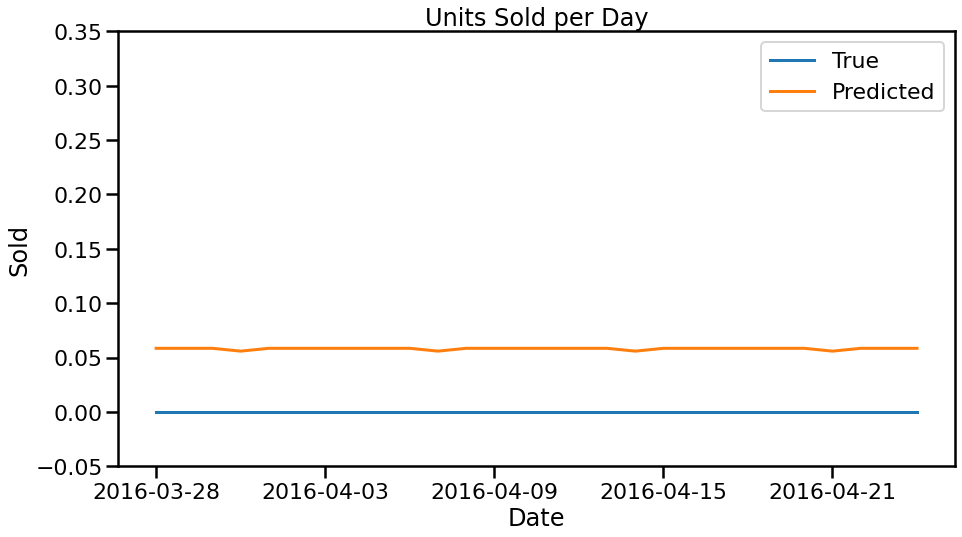

In [48]:
# visualize the models performance on an item with no sales
pred = pd.Series(preds[17], index=trues[17].index)
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=trues[17], ax=ax)
sns.lineplot(data=pred, ax=ax)
ax.set_xticks(['2016-03-28', '2016-04-03', '2016-04-09', '2016-04-15', '2016-04-21'])
ax.set_ybound(.35)
ax.set_ylim(-.05)
ax.set_ylabel('Sold')
ax.set_xlabel('Date')
ax.set_title('Units Sold per Day')
ax.legend(['True', 'Predicted']);

In [49]:
# Find the item with the most sales
CA1_HOB_price.groupby('id')['sales'].sum().sort_values().tail(1)

id
HOBBIES_1_348_CA_1_validation    22498
Name: sales, dtype: int64

In [50]:
# print the index of the item above 
for i, item in enumerate(items):
    if item == 'HOBBIES_1_348_CA_1_validation':
        print(i)

339


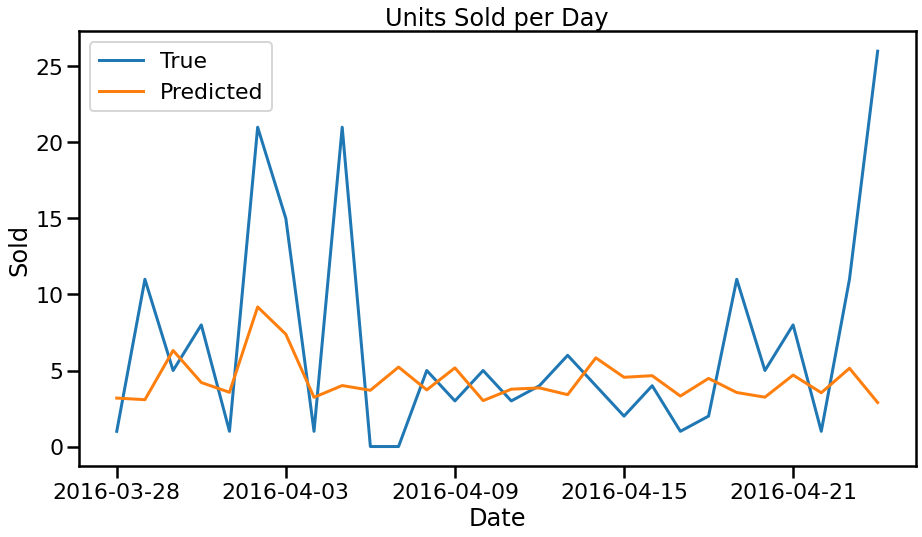

In [51]:
# visualize the models performance on the item with the most sales
pred = pd.Series(preds[339], index=trues[339].index)
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=trues[339], ax=ax)
sns.lineplot(data=pred, ax=ax)
ax.legend(['True', 'Predicted'])
ax.set_ylabel('Sold')
ax.set_xlabel('Date')
ax.set_xticks(['2016-03-28', '2016-04-03', '2016-04-09', '2016-04-15', '2016-04-21'])
ax.set_title('Units Sold per Day');

In [52]:
# list of total number of items predicted to sell and actually sold
monthly_preds = []
monthly_trues = []
for i in range(28):
    daily_preds = []
    for pred in preds:
        daily_preds.append(pred[i])
    monthly_preds.append(sum(daily_preds))
    daily_trues = []
    for true in trues:
        daily_trues.append(true[i])
    monthly_trues.append(sum(daily_trues))

In [53]:
# add datetime index to the lists made above
monthly_trues = pd.Series(monthly_trues, index=trues[0].index)
monthly_preds = pd.Series(monthly_preds, index=trues[0].index)

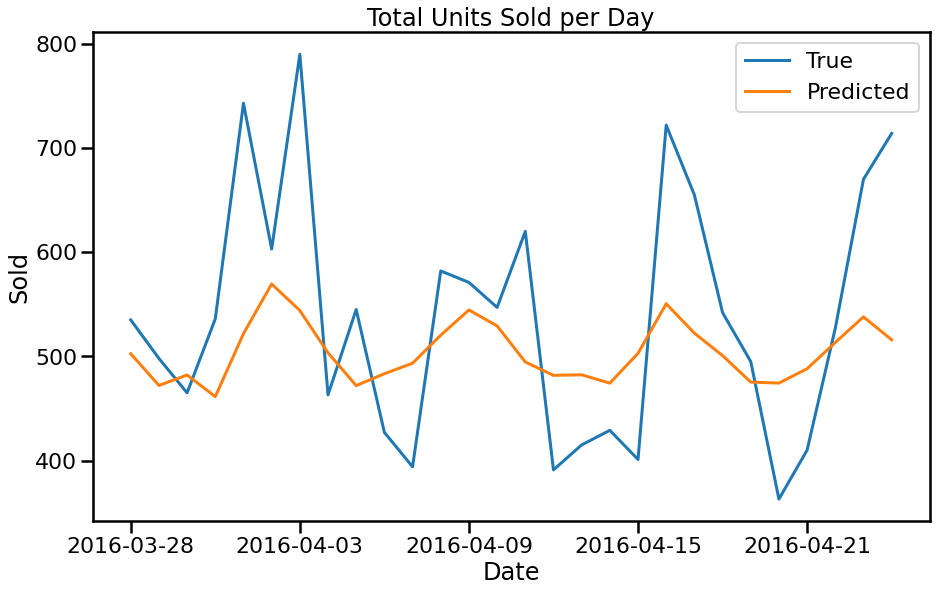

In [54]:
# visualize how the model predicted total units sold per day
fig, ax = plt.subplots(figsize=(15,9))
sns.lineplot(data=monthly_trues, ax=ax)
sns.lineplot(data=monthly_preds, ax=ax)
ax.legend(['True', 'Predicted'])
ax.legend(['True', 'Predicted'])
ax.set_ylabel('Sold')
ax.set_xlabel('Date')
ax.set_xticks(['2016-03-28', '2016-04-03', '2016-04-09', '2016-04-15', '2016-04-21'])
ax.set_title('Total Units Sold per Day');

In [55]:
# 28 day total of units predicted to be sold for every item 
pred_totals = []
for pred in preds:
    pred_totals.append(sum(pred))

In [56]:
# 28 day total of units actually sold for every item
true_totals = []
for true in trues:
    true_totals.append(sum(true))

In [57]:
# return root mean squared error between these totals
mean_squared_error(true_totals, pred_totals, squared=False)

13.540318574978302

In [58]:
# total predicted units sold for highest volume item
sum(preds[339])

121.97571086180315

In [59]:
# actual units sold for highest volume item
sum(trues[339])

185

### Most Important Features

The top 9 feature importances stayed the same for the HOBBIES departments, but the 10th feature of November was replaced with the day Tuesday.

In [60]:
imp_graph = dict(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)[:10])

In [61]:
sns.set_palette(sns.color_palette("light:b"))

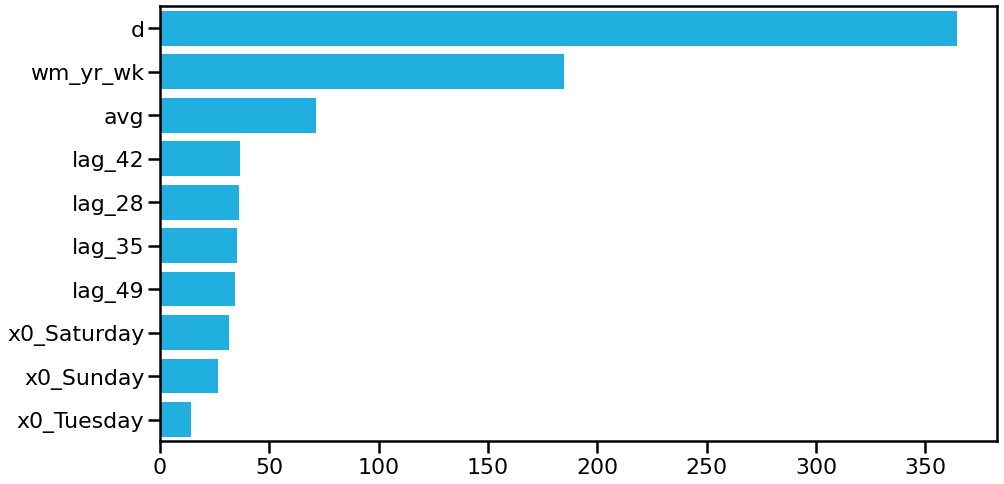

In [62]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x=list(imp_graph.values()), y=list(imp_graph.keys()), color='deepskyblue', ax=ax);